In [2]:
%%javascript
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from __future__ import print_function
import serial
import time

In [23]:
n_values = 2000
values = np.zeros((n_values, 2))
values.shape

(2000, 2)

# Modification 1: calculate test_signal in setup()

__Purpose__: Rather than copying and pasting a large array of data into the code, just calculate the data in setup().

## SIMULATED_SIGNAL_SELECTION is 1 (calculated raised cosine signal)

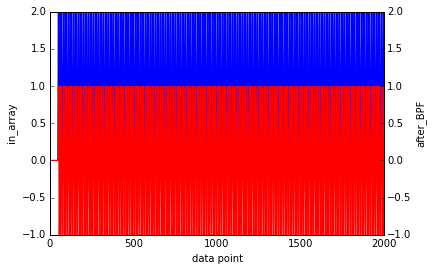

In [20]:
teensy = serial.Serial('/dev/cu.usbmodem213141', 115200)
temp = []
for i in range(n_values):
    if i == 0:
        teensy.flushInput()
    temp.append( teensy.readline().strip().split(',') )

teensy.close()

for i in range(50,n_values,1):
    values[i,0] = float (temp[i][0])
    values[i,1] = float (temp[i][1])

fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
ax.set_ylim(-1, 2)
ax2.set_ylim(-1, 2)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point');

(40, 140)

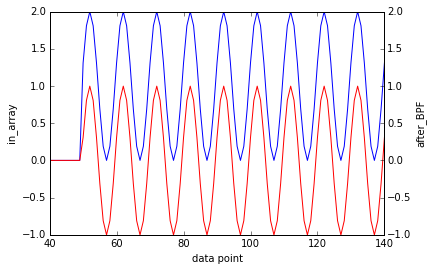

In [24]:
fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
ax.set_ylim(-1, 2)
ax2.set_ylim(-1, 2)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point')
ax.set_xlim(40,140)

## SIMULATED_SIGNAL_SELECTION is 2 (unit impulse function)

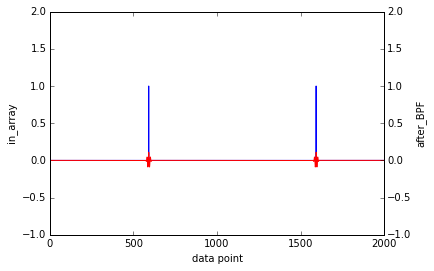

In [25]:
teensy = serial.Serial('/dev/cu.usbmodem213141', 115200)
temp = []
for i in range(n_values):
    if i == 0:
        teensy.flushInput()
    temp.append( teensy.readline().strip().split(',') )

teensy.close()

for i in range(50,n_values,1):
    values[i,0] = float (temp[i][0])
    values[i,1] = float (temp[i][1])

fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
ax.set_ylim(-1, 2)
ax2.set_ylim(-1, 2)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point');

(570, 610)

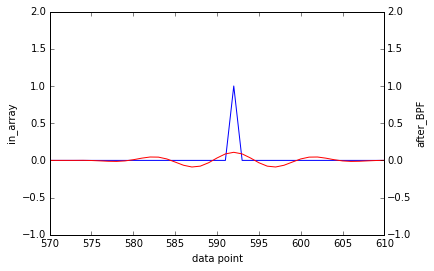

In [27]:
fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
ax.set_ylim(-1, 2)
ax2.set_ylim(-1, 2)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point')
ax.set_xlim(570,610)

__Conclusion__: Both of these work fine

# To do next

1. Add two more simulated signals:
  - cosine from the look up table rather than directly calculated (make this option 3)
  - rectangular pulse
2. Change writing to serial
  - Don't do this in the interrupt
  - Write in loop() for an arbitrarily selected period (i.e., number of times the interrupt is called). For example if the period is set to 10, then values are written every 10 times the interrupt is called.
3. Add cosine multiplication. Must be extremely careful about indexing. I think it's going to be something like...
4. Add low pass filter

# 1. Make up the look up table

cosine freq = 500.0 Hz
sampling freq = 5000.0 Hz
cosine look up table:
 [ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699]


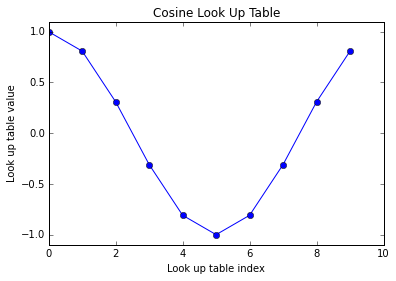

In [25]:
t_inter = 200
n_samp_cos = 10
freq_samp = 1.0/((t_inter*1e-6))
freq_cos = 1.0/((t_inter*1e-6)*n_samp_cos)
print('cosine freq =', freq_cos, 'Hz')
print('sampling freq =', freq_samp, 'Hz')

lut = np.zeros(n_samp_cos)
lut = np.cos(2.0*np.pi*np.arange(n_samp_cos)/n_samp_cos)
print('cosine look up table:\n', lut)

fig, ax = plt.subplots()
ax.plot(range(n_samp_cos), lut, 'o-')
ax.set_xlim(0 ,n_samp_cos)
ax.set_ylim(-1.1, 1.1)
ax.set_title('Cosine Look Up Table')
ax.set_xlabel('Look up table index')
ax.set_ylabel('Look up table value');

# 2. Make a signal that is similar to the DAC using lut

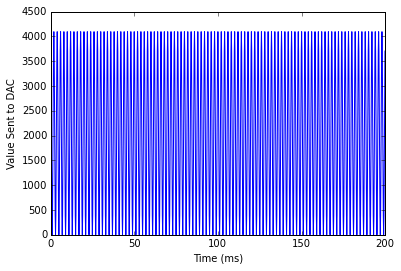

In [26]:
n_total_samples = 1000
dac_output = np.zeros(n_total_samples)
time_dac_output = np.zeros(n_total_samples)
for i in range(n_total_samples):
    lut_index = np.mod(i,n_samp_cos)
    dac_output[i] = 4095 * 0.5*(1.0 + lut[lut_index])
    time_dac_output[i] = i*t_inter * 1e-3  #convert to msec from usec

fig, ax = plt.subplots()
ax.plot(time_dac_output, dac_output)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Value Sent to DAC');

# 3. Output values from dac_output and put in teensy code

In [27]:
dac_output


array([ 4095.        ,  3703.96229598,  2680.21229598,  1414.78770402,
         391.03770402,     0.        ,   391.03770402,  1414.78770402,
        2680.21229598,  3703.96229598,  4095.        ,  3703.96229598,
        2680.21229598,  1414.78770402,   391.03770402,     0.        ,
         391.03770402,  1414.78770402,  2680.21229598,  3703.96229598,
        4095.        ,  3703.96229598,  2680.21229598,  1414.78770402,
         391.03770402,     0.        ,   391.03770402,  1414.78770402,
        2680.21229598,  3703.96229598,  4095.        ,  3703.96229598,
        2680.21229598,  1414.78770402,   391.03770402,     0.        ,
         391.03770402,  1414.78770402,  2680.21229598,  3703.96229598,
        4095.        ,  3703.96229598,  2680.21229598,  1414.78770402,
         391.03770402,     0.        ,   391.03770402,  1414.78770402,
        2680.21229598,  3703.96229598,  4095.        ,  3703.96229598,
        2680.21229598,  1414.78770402,   391.03770402,     0.        ,
      

# 4. Run Teensy code, read here and plot

In [28]:
teensy = serial.Serial("/dev/ttyACM0", 115200)
temp = []
for i in range(n_values):
    if i == 0:
        teensy.flushInput()
    temp.append( teensy.readline().strip().split(',') )

teensy.close()
temp

[['.62341'],
 ['3703.96', '1652.58569'],
 ['2680.21', '628.83563'],
 ['1414.79', '-636.58868'],
 ['391.04', '-1660.33850'],
 ['0.00', '-2051.37622'],
 ['391.04', '-1660.33838'],
 ['1414.79', '-636.58862'],
 ['2680.21', '628.83569'],
 ['3703.96', '1652.58545'],
 ['4095.00', '2043.62341'],
 ['3703.96', '1652.58569'],
 ['2680.21', '628.83563'],
 ['1414.79', '-636.58868'],
 ['391.04', '-1660.33850'],
 ['0.00', '-2051.37622'],
 ['391.04', '-1660.33838'],
 ['1414.79', '-636.58862'],
 ['2680.21', '628.83569'],
 ['3703.96', '1652.58545'],
 ['4095.00', '2043.62341'],
 ['3703.96', '1652.58569'],
 ['2680.21', '628.83563'],
 ['1414.79', '-636.58868'],
 ['391.04', '-1660.33850'],
 ['0.00', '-2051.37622'],
 ['391.04', '-1660.33838'],
 ['1414.79', '-636.58862'],
 ['2680.21', '628.83569'],
 ['3703.96', '1652.58545'],
 ['4095.00', '2043.62341'],
 ['3703.96', '1652.58569'],
 ['2680.21', '628.83563'],
 ['1414.79', '-636.58868'],
 ['391.04', '-1660.33850'],
 ['0.00', '-2051.37622'],
 ['391.04', '-1660.338

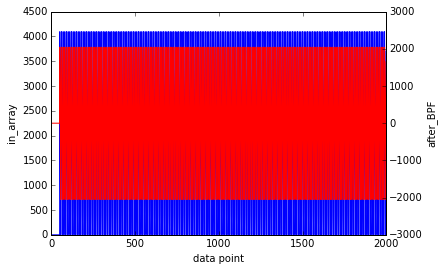

In [29]:
for i in range(50,n_values,1):
    values[i,0] = float (temp[i][0])
    values[i,1] = float (temp[i][1])

fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
#ax.set_ylim(-1, 2)
#ax2.set_ylim(-1, 2)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point');

(570, 610)

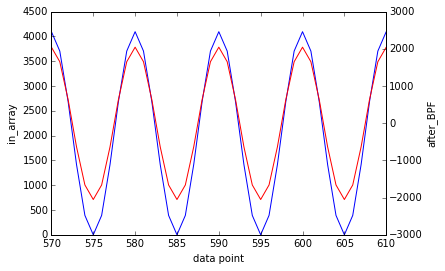

In [31]:
fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
#ax.set_ylim(-3, 3)
#ax2.set_ylim(-3, 3)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point')
ax.set_xlim(570,610)

# Test with a rectangular pulses

In [18]:
def rect(T):
    """create a centered rectangular pulse of width $T"""
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, shape):
    """create a train of pulses over $t at times $at and shape $shape"""
    return np.sum(shape(t - at[:,np.newaxis]), axis=0)

sig = pulse_train(
    t=np.arange(1000),              # time domain
    at=np.array([0, 200, 300, 400, 500, 600, 700, 800]),  # times of pulses
    shape=rect(10)                 # shape of pulse
)

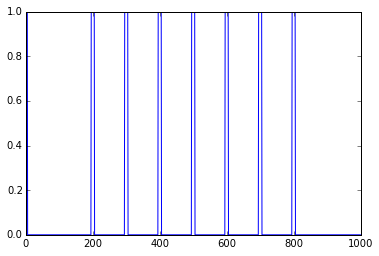

In [19]:
plt.plot(sig)

In [24]:
teensy = serial.Serial("/dev/ttyACM0", 115200)
temp = []
for i in range(n_values):
    if i == 0:
        teensy.flushInput()
    temp.append( teensy.readline().strip().split(',') )

teensy.close()
temp

[['0.10891'],
 ['0.00', '0.08999'],
 ['0.00', '0.04603'],
 ['0.00', '0.00049'],
 ['0.00', '-0.02959'],
 ['0.00', '-0.03870'],
 ['0.00', '-0.03172'],
 ['0.00', '-0.01832'],
 ['0.00', '-0.00677'],
 ['0.00', '-0.00070'],
 ['0.00', '0.00065'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0.00000'],
 ['0.00', '0

In [21]:
len(sig)


1000

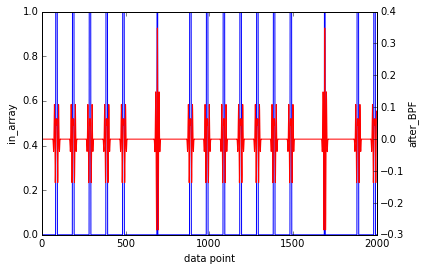

In [25]:
for i in range(50,n_values,1):
    values[i,0] = float (temp[i][0])
    values[i,1] = float (temp[i][1])

fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
#ax.set_ylim(-1, 2)
#ax2.set_ylim(-1, 2)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point');

(150, 250)

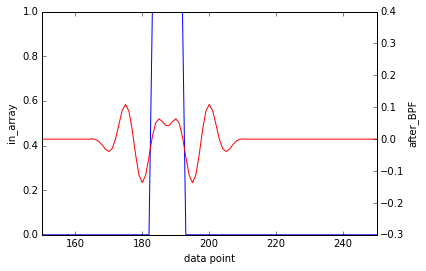

In [29]:
fig, ax = plt.subplots()
ax.plot(range(n_values), values[:,0])
ax2 = ax.twinx()
ax2.plot(range(n_values), values[:,1], 'r')
#ax.set_ylim(-3, 3)
#ax2.set_ylim(-3, 3)
ax.set_ylabel('in_array')
ax2.set_ylabel('after_BPF')
ax.set_xlabel('data point')
ax.set_xlim(150,250)